In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from merge_years.import_data import get_full_data

In [2]:
full_data = get_full_data('../raw_data')

In [3]:
len(full_data.columns)

40

### Splitting data into positions ***

In [4]:
mid_data = full_data[full_data.position == "MID"]
def_data = full_data[full_data.position == "DEF"]
fwd_data = full_data[full_data.position == "FWD"]
gk_data = full_data[full_data.position == "GK"]

### SELECTING FEATURES ---------- (useless)

features were selected with common sense and little data exploration

In [5]:
known_features = ['name', 'opponent_team','kickoff_time','was_home',
                 'opponent_level','team_level','dreamteam_yearly_average','GW',
                  'team_id','season','kickoff_date','position']

game_features = ['name','assists', 'bonus', 'bps', 'clean_sheets', 
                 'creativity','goals_conceded','threat',
                 'goals_scored', 'ict_index','influence',
                 'kickoff_time', 'minutes','own_goals',
                 'penalties_missed', 'penalties_saved',
                 'red_cards', 'saves','transfers_balance',
                 'value','yellow_cards','team_a_score',
                 'team_h_score','total_points']

know_feat_df = full_data[known_features]
game_features = full_data[game_features]

In [6]:
game_features = ['name','assists', 'bonus', 'bps', 'clean_sheets','creativity','goals_conceded',
                     'threat','goals_scored', 'ict_index','influence','kickoff_time', 'minutes',
                     'own_goals','penalties_missed', 'penalties_saved','red_cards', 'saves',
                     'transfers_balance','value','yellow_cards','team_a_score','team_h_score',
                     'total_points']
len(game_features)

24

In [20]:
players_data.columns


Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'selected',
       'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW', 'season', 'position',
       'dreamteam_yearly_average', 'team_id', 'team_name', 'opponent_level',
       'team_level', 'kickoff_date'],
      dtype='object')

### Function 

In [32]:
def roll_match_features(df, roll=2, method='mean'):
    '''
    Returns the lagged dataframe with a chosen method and lagging window
    Adds a 'real_total_points' column
    '''
    df = df[df.season > 19]
    # splitting into game features and known features
    known_features = ['name', 'opponent_team','kickoff_time','was_home',
                      'opponent_level','team_level','dreamteam_yearly_average','GW',
                      'team_id','season','kickoff_date','position']

    game_features = ['name','assists', 'bonus', 'bps', 'clean_sheets','creativity','goals_conceded',
                     'threat','goals_scored', 'ict_index','influence','kickoff_time', 'minutes',
                     'own_goals','penalties_missed', 'penalties_saved','red_cards', 'saves',
                     'transfers_balance','value','yellow_cards','team_a_score','team_h_score',
                     'total_points']
    
    df_pre_match = df[known_features]
    df_match = df[game_features]
    
    # roll with a given method
    rolled_df = df_match.groupby('name')
    if method == 'mean':
        rolled_df = rolled_df.rolling(roll,closed='left').mean()
    elif method == 'max':
        rolled_df = rolled_df.rolling(roll,closed='left').max()
    elif method == 'min':
        rolled_df = rolled_df.rolling(roll,closed='left').min()
    else: #do a mean() meathod
        rolled_df = rolled_df.rolling(roll,closed='left').mean()

    rolled_df.reset_index(inplace=True)
    
    # Add back the un-lagged, real total_points
    rolled_df['real_total_points'] = np.array(df_match['total_points'])
    
    # Rename the rolled columns to how they were rolled
    game_features.remove('name')
    game_features_rolled=[]
    for feat in game_features:
        game_features_rolled.append('r_' + feat)
    feat_new_names_dict = dict(zip(game_features, game_features_rolled))
    rolled_df.rename(feat_new_names_dict,axis=1, inplace=True)
    
    # Join the features available pre-match
    data = rolled_df.join(df_pre_match.reset_index()[['was_home','GW','position','season','team_level','opponent_level']])
    
    # Delete the NaN values fromn the rolled 'r_total_points' columns
    data = data[~data.r_total_points.isnull()]
    
    return data

In [8]:
def player_df(player):
    return roll_match_features(full_data[full_data['name'] == player])

In [ ]:
test_full_data = roll_match_features(full_data)

### exploring correlations USELESS

In [9]:
fwd=roll_match_features(fwd_data)

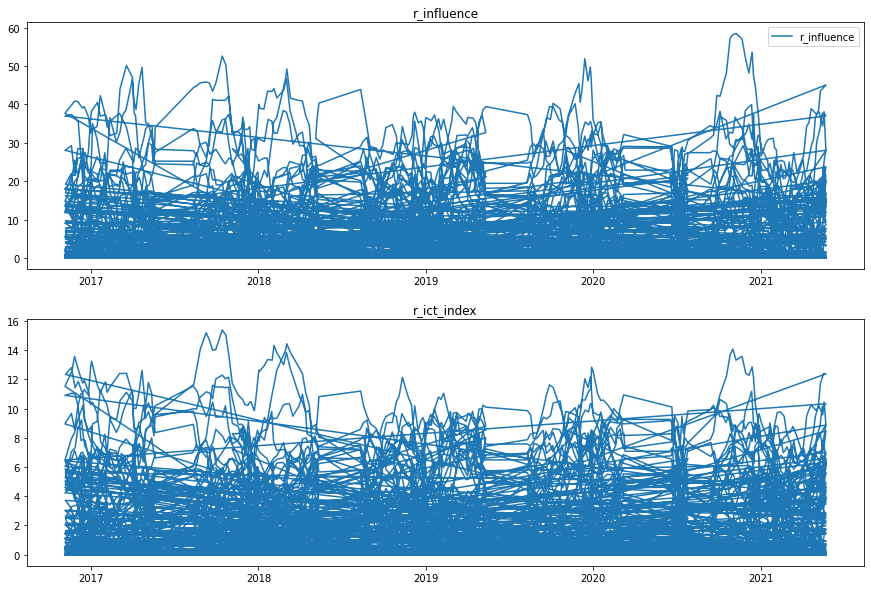

In [10]:
# Start a figure
plt.figure(figsize=(15,10))

#features
data = fwd
x = 'kickoff_date'
y = 'r_influence'
y2 = 'r_ict_index'

# First subplot
plt.subplot(2,1,1)
plt.plot(data[x], data[y], label=y)
plt.title(y)
plt.legend()

# Second subplot
plt.subplot(2,1,2) 
plt.plot(data[x], data[y2], label = y2)
plt.title(y2)

# Global figure methods
plt.suptitle('')
plt.show()


### model attempt

##### meh

*** TO DO ***
- Missing Values:
    - r_team_a_score / r_team_h_score
    - position
- ENCODE 
    - "was_home"
    - "position"
- SCALING
- (LATER): missing values for "team_level","opponent_team","opponent_level"

#### Pre Processing:


In [116]:
data.isnull().sum().sort_values(ascending=False)

r_team_h_score         585
r_team_a_score         585
position                16
r_assists                0
season                   0
GW                       0
was_home                 0
real_total_points        0
r_total_points           0
r_yellow_cards           0
r_value                  0
r_transfers_balance      0
r_saves                  0
r_red_cards              0
name                     0
r_penalties_missed       0
r_own_goals              0
r_minutes                0
r_influence              0
r_ict_index              0
r_goals_scored           0
r_threat                 0
r_goals_conceded         0
r_creativity             0
r_clean_sheets           0
r_bps                    0
r_bonus                  0
r_penalties_saved        0
dtype: int64

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

def pre_processing(data):
    # Adding the missing r_team_scores:
    imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
    data["r_team_h_score"] = imp.fit_transform(data[["r_team_h_score"]])
    data["r_team_a_score"] = imp.fit_transform(data[["r_team_a_score"]])
    
    # Adding missing positions to 1 defender (15 rows)
    imp_string = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value="DEF")
    data["position"] = imp_string.fit_transform(data[["position"]])
    
    if len(data.position.unique()) == 4:
        # OHE positions if ['DEF','FWD','GK','MID']
        enc=OneHotEncoder()
        enc.fit(data[['position']])
        positions=enc.transform(data[['position']]).toarray()
        data["DEF"], data["FWD"], data['GK'], data['MID'] = positions.T
    else:
        pass
    
    # Was_home
    data['was_home'] = data.was_home.map(int)
        
    return data

#### Split X & y

In [6]:
def split(data, roll=2):
    # Train & Test
    test_data = data[(data.season > 20) & (data.GW >= 34-roll)]
    train_data = data[~((data.season > 20) & (data.GW >= 34-roll))]
    
    # X & y train
    X_train = train_data.drop('real_total_points', axis = 1)
    y_train = train_data.real_total_points
    
    # X & y test
    X_test = test_data.drop('real_total_points', axis = 1)
    y_test = test_data.real_total_points
    
    return (X_train,X_test,y_train,y_test)

#### SCALING

In [35]:
from sklearn.preprocessing import StandardScaler

def scale(X_train, X_test,drop=["name","season","position","GW"]):
    # drop features
    X_train.drop(drop,axis=1,inplace=True)
    X_test_prescaled = X_test.drop(drop,axis=1)
    print(f"COLUMNS USED: {list(X_train.columns)}")

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test_prescaled)
    return (X_train_scaled, X_test_scaled)

#### ALL IN ONE

In [22]:
def model_ready(df, drop=drop, roll=3):
    '''
    Can take "full_data" or "fwd_data" as input
    Returns X_train_scaled, X_test_scaled, y_train y_test
    '''
    # Roll the game-related features, keep the known features
    unclean_data = roll_match_features(df, roll=roll)
    
    # preprocess
    data = pre_processing(unclean_data)
    
    #split
    X_train, X_test, y_train, y_test = split(data, roll=roll)
    
    #scale
    X_train_scaled, X_test_scaled = scale(X_train,X_test,drop=drop)
    
    print(f"""
    MOVING AVERAGE WINDOW (roll) = {roll}
    """)
    
    return(X_train_scaled, X_test_scaled, X_test, y_train, y_test)

## Model

#### model design

In [40]:
from tensorflow.keras import regularizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

reg_l1 = regularizers.L1(0.01)

In [139]:
def init_model(dim, learn = 0.00003, dropout = False):
    model = models.Sequential()
    
    model.add(layers.Dense(45, input_dim=dim, activation='relu'))
    if dropout:
        model.add(layers.Dropout(rate = 0.01))
    pass

    model.add(layers.Dense(35, activation='relu', kernel_regularizer=reg_l1))
    if dropout:
        model.add(layers.Dropout(rate = 0.01))
    pass

    model.add(layers.Dense(15, activation='relu'))
    if dropout:
        model.add(layers.Dropout(rate = 0.01))
    
    # output layer for regression task
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=Adam(learning_rate=learn),
                  metrics=['mae'])
    return model

#### model training neural network = 35, 25, 10

Model is trained with rows of payers who played > 1 minute only

Model is trained on years 20/21 only in order to have team level and opponent team level 


In [38]:
drop = ["name","level_1","season","position","GW"]
roll = 2
players_data = full_data[full_data['minutes'] > 0]

X_train_scaled, X_test_scaled, x_test, y_train, y_test = model_ready(players_data, drop, roll)
X_train_scaled.shape

DROPED COLUMNS : ['name', 'level_1', 'season', 'position', 'GW']
COLUMNS USED: ['r_assists', 'r_bonus', 'r_bps', 'r_clean_sheets', 'r_creativity', 'r_goals_conceded', 'r_threat', 'r_goals_scored', 'r_ict_index', 'r_influence', 'r_minutes', 'r_own_goals', 'r_penalties_missed', 'r_penalties_saved', 'r_red_cards', 'r_saves', 'r_transfers_balance', 'r_value', 'r_yellow_cards', 'r_team_a_score', 'r_team_h_score', 'r_total_points', 'was_home', 'team_level', 'opponent_level', 'DEF', 'FWD', 'GK', 'MID']
MOVING AVERAGE WINDOW (roll) = 2


(17788, 29)

In [53]:
model = init_model(29,learn = 0.00003)
es = EarlyStopping(patience=6)

history = model.fit(X_train_scaled, y_train, 
                  batch_size=32, 
                  epochs=500, 
                  validation_split=0.2,
                  callbacks=[es])

Epoch 1/500
445/445 [==============================] - 1s 1ms/step - loss: 15.8333 - mae: 2.4454 - val_loss: 15.5210 - val_mae: 2.3636
Epoch 2/500
445/445 [==============================] - 0s 1ms/step - loss: 12.9638 - mae: 2.1112 - val_loss: 13.1891 - val_mae: 2.1643
Epoch 3/500
445/445 [==============================] - 0s 1ms/step - loss: 11.5164 - mae: 2.0535 - val_loss: 12.0961 - val_mae: 2.1568
Epoch 4/500
445/445 [==============================] - 0s 1ms/step - loss: 10.8626 - mae: 2.0728 - val_loss: 11.5797 - val_mae: 2.1766
Epoch 5/500
445/445 [==============================] - 1s 1ms/step - loss: 10.5058 - mae: 2.0870 - val_loss: 11.2598 - val_mae: 2.1871
Epoch 6/500
445/445 [==============================] - 0s 1ms/step - loss: 10.2626 - mae: 2.0859 - val_loss: 11.0285 - val_mae: 2.1901
Epoch 7/500
445/445 [==============================] - 0s 1ms/step - loss: 10.0813 - mae: 2.0853 - val_loss: 10.8530 - val_mae: 2.1889
Epoch 8/500
445/445 [==============================] - 

Epoch 62/500
445/445 [==============================] - 0s 1ms/step - loss: 8.8336 - mae: 2.0346 - val_loss: 9.8060 - val_mae: 2.1762
Epoch 63/500
445/445 [==============================] - 0s 1ms/step - loss: 8.8269 - mae: 2.0219 - val_loss: 9.8052 - val_mae: 2.1888
Epoch 64/500
445/445 [==============================] - 0s 1ms/step - loss: 8.8190 - mae: 2.0323 - val_loss: 9.7961 - val_mae: 2.1832
Epoch 65/500
445/445 [==============================] - 0s 1ms/step - loss: 8.8127 - mae: 2.0256 - val_loss: 9.7942 - val_mae: 2.1913
Epoch 66/500
445/445 [==============================] - 0s 1ms/step - loss: 8.8056 - mae: 2.0276 - val_loss: 9.7890 - val_mae: 2.1945
Epoch 67/500
445/445 [==============================] - 0s 1ms/step - loss: 8.7982 - mae: 2.0343 - val_loss: 9.7765 - val_mae: 2.1811
Epoch 68/500
445/445 [==============================] - 0s 1ms/step - loss: 8.7912 - mae: 2.0312 - val_loss: 9.7696 - val_mae: 2.1755
Epoch 69/500
445/445 [==============================] - 0s 1ms

Epoch 123/500
445/445 [==============================] - 0s 1ms/step - loss: 8.5023 - mae: 2.0233 - val_loss: 9.5525 - val_mae: 2.1924
Epoch 124/500
445/445 [==============================] - 0s 1ms/step - loss: 8.4981 - mae: 2.0225 - val_loss: 9.5486 - val_mae: 2.1896
Epoch 125/500
445/445 [==============================] - 0s 1ms/step - loss: 8.4938 - mae: 2.0227 - val_loss: 9.5436 - val_mae: 2.1859
Epoch 126/500
445/445 [==============================] - 0s 1ms/step - loss: 8.4896 - mae: 2.0187 - val_loss: 9.5443 - val_mae: 2.1917
Epoch 127/500
445/445 [==============================] - 0s 1ms/step - loss: 8.4866 - mae: 2.0233 - val_loss: 9.5385 - val_mae: 2.1865
Epoch 128/500
445/445 [==============================] - 0s 1ms/step - loss: 8.4823 - mae: 2.0183 - val_loss: 9.5369 - val_mae: 2.1937
Epoch 129/500
445/445 [==============================] - 0s 1ms/step - loss: 8.4790 - mae: 2.0244 - val_loss: 9.5312 - val_mae: 2.1845
Epoch 130/500
445/445 [==============================] 

445/445 [==============================] - 0s 1ms/step - loss: 8.3005 - mae: 2.0171 - val_loss: 9.4099 - val_mae: 2.1943
Epoch 184/500
445/445 [==============================] - 0s 1ms/step - loss: 8.2976 - mae: 2.0135 - val_loss: 9.4077 - val_mae: 2.1978
Epoch 185/500
445/445 [==============================] - 0s 1ms/step - loss: 8.2945 - mae: 2.0156 - val_loss: 9.4098 - val_mae: 2.1989
Epoch 186/500
445/445 [==============================] - 0s 1ms/step - loss: 8.2904 - mae: 2.0216 - val_loss: 9.3997 - val_mae: 2.1833
Epoch 187/500
445/445 [==============================] - 0s 1ms/step - loss: 8.2891 - mae: 2.0146 - val_loss: 9.3969 - val_mae: 2.1777
Epoch 188/500
445/445 [==============================] - 0s 1ms/step - loss: 8.2869 - mae: 2.0087 - val_loss: 9.4052 - val_mae: 2.2005
Epoch 189/500
445/445 [==============================] - 0s 1ms/step - loss: 8.2846 - mae: 2.0181 - val_loss: 9.3964 - val_mae: 2.1903
Epoch 190/500
445/445 [==============================] - 0s 1ms/step 

Epoch 244/500
445/445 [==============================] - 0s 1ms/step - loss: 8.1532 - mae: 2.0091 - val_loss: 9.3248 - val_mae: 2.1965
Epoch 245/500
445/445 [==============================] - 0s 1ms/step - loss: 8.1513 - mae: 2.0099 - val_loss: 9.3236 - val_mae: 2.1943
Epoch 246/500
445/445 [==============================] - 0s 1ms/step - loss: 8.1496 - mae: 2.0087 - val_loss: 9.3223 - val_mae: 2.1932
Epoch 247/500
445/445 [==============================] - 0s 1ms/step - loss: 8.1471 - mae: 2.0118 - val_loss: 9.3179 - val_mae: 2.1847
Epoch 248/500
445/445 [==============================] - 0s 1ms/step - loss: 8.1455 - mae: 2.0072 - val_loss: 9.3173 - val_mae: 2.1893
Epoch 249/500
445/445 [==============================] - 0s 1ms/step - loss: 8.1436 - mae: 2.0079 - val_loss: 9.3228 - val_mae: 2.1951
Epoch 250/500
445/445 [==============================] - 0s 1ms/step - loss: 8.1413 - mae: 2.0065 - val_loss: 9.3259 - val_mae: 2.2011
Epoch 251/500
445/445 [==============================] 

In [43]:
y_eval = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_test_scaled)
y_eval

59/59 [==============================] - 0s 770us/step - loss: 8.4347 - mae: 2.0382


[8.434713363647461, 2.0382473468780518]

#### model training neural network = 45, 35, 15

In [136]:
drop = ["name","level_1","season","position","GW"]
roll = 2
players_data = full_data[full_data['minutes'] > 0]

X_train_scaled, X_test_scaled, x_test, y_train, y_test = model_ready(players_data, drop, roll)
X_train_scaled.shape

DROPED COLUMNS : ['name', 'level_1', 'season', 'position', 'GW']
COLUMNS USED: ['r_assists', 'r_bonus', 'r_bps', 'r_clean_sheets', 'r_creativity', 'r_goals_conceded', 'r_threat', 'r_goals_scored', 'r_ict_index', 'r_influence', 'r_minutes', 'r_own_goals', 'r_penalties_missed', 'r_penalties_saved', 'r_red_cards', 'r_saves', 'r_transfers_balance', 'r_value', 'r_yellow_cards', 'r_team_a_score', 'r_team_h_score', 'r_total_points', 'was_home', 'team_level', 'opponent_level', 'DEF', 'FWD', 'GK', 'MID']
MOVING AVERAGE WINDOW (roll) = 2


(17788, 29)

In [140]:
model = init_model(29,learn = 0.00003)
es = EarlyStopping(patience=6)

history = model.fit(X_train_scaled, y_train, 
                  batch_size=32, 
                  epochs=500, 
                  validation_split=0.2,
                  callbacks=[es])

Epoch 1/500
445/445 [==============================] - 1s 1ms/step - loss: 20.5106 - mae: 3.1065 - val_loss: 21.0392 - val_mae: 3.1044
Epoch 2/500
445/445 [==============================] - 1s 1ms/step - loss: 17.7598 - mae: 2.6845 - val_loss: 17.7658 - val_mae: 2.6045
Epoch 3/500
445/445 [==============================] - 1s 1ms/step - loss: 14.9032 - mae: 2.2238 - val_loss: 14.8799 - val_mae: 2.2133
Epoch 4/500
445/445 [==============================] - 1s 1ms/step - loss: 12.6789 - mae: 2.0048 - val_loss: 12.9534 - val_mae: 2.1332
Epoch 5/500
445/445 [==============================] - 0s 1ms/step - loss: 11.5135 - mae: 2.0126 - val_loss: 12.2344 - val_mae: 2.1701
Epoch 6/500
445/445 [==============================] - 1s 1ms/step - loss: 11.0788 - mae: 2.0498 - val_loss: 11.9011 - val_mae: 2.1920
Epoch 7/500
445/445 [==============================] - 1s 1ms/step - loss: 10.8378 - mae: 2.0646 - val_loss: 11.6654 - val_mae: 2.2035
Epoch 8/500
445/445 [==============================] - 

Epoch 62/500
445/445 [==============================] - 1s 1ms/step - loss: 8.8821 - mae: 2.0282 - val_loss: 9.8202 - val_mae: 2.1839
Epoch 63/500
445/445 [==============================] - 1s 1ms/step - loss: 8.8710 - mae: 2.0267 - val_loss: 9.8098 - val_mae: 2.1812
Epoch 64/500
445/445 [==============================] - 1s 1ms/step - loss: 8.8598 - mae: 2.0253 - val_loss: 9.7973 - val_mae: 2.1803
Epoch 65/500
445/445 [==============================] - 1s 1ms/step - loss: 8.8490 - mae: 2.0266 - val_loss: 9.7862 - val_mae: 2.1787
Epoch 66/500
445/445 [==============================] - 0s 1ms/step - loss: 8.8382 - mae: 2.0232 - val_loss: 9.7848 - val_mae: 2.1867
Epoch 67/500
445/445 [==============================] - 1s 1ms/step - loss: 8.8275 - mae: 2.0255 - val_loss: 9.7796 - val_mae: 2.1898
Epoch 68/500
445/445 [==============================] - 1s 1ms/step - loss: 8.8169 - mae: 2.0234 - val_loss: 9.7757 - val_mae: 2.1949
Epoch 69/500
445/445 [==============================] - 1s 1ms

Epoch 123/500
445/445 [==============================] - 1s 1ms/step - loss: 8.4408 - mae: 2.0180 - val_loss: 9.4497 - val_mae: 2.1826
Epoch 124/500
445/445 [==============================] - 1s 1ms/step - loss: 8.4361 - mae: 2.0173 - val_loss: 9.4376 - val_mae: 2.1777
Epoch 125/500
445/445 [==============================] - 0s 1ms/step - loss: 8.4313 - mae: 2.0132 - val_loss: 9.4498 - val_mae: 2.1952
Epoch 126/500
445/445 [==============================] - 1s 1ms/step - loss: 8.4273 - mae: 2.0206 - val_loss: 9.4342 - val_mae: 2.1823
Epoch 127/500
445/445 [==============================] - 0s 1ms/step - loss: 8.4229 - mae: 2.0174 - val_loss: 9.4344 - val_mae: 2.1858
Epoch 128/500
445/445 [==============================] - 0s 1ms/step - loss: 8.4172 - mae: 2.0215 - val_loss: 9.4239 - val_mae: 2.1763
Epoch 129/500
445/445 [==============================] - 0s 1ms/step - loss: 8.4142 - mae: 2.0176 - val_loss: 9.4199 - val_mae: 2.1747
Epoch 130/500
445/445 [==============================] 

445/445 [==============================] - 1s 1ms/step - loss: 8.2251 - mae: 2.0105 - val_loss: 9.3004 - val_mae: 2.1952
Epoch 184/500
445/445 [==============================] - 0s 1ms/step - loss: 8.2223 - mae: 2.0139 - val_loss: 9.2908 - val_mae: 2.1837
Epoch 185/500
445/445 [==============================] - 1s 1ms/step - loss: 8.2196 - mae: 2.0139 - val_loss: 9.2850 - val_mae: 2.1770
Epoch 186/500
445/445 [==============================] - 1s 1ms/step - loss: 8.2185 - mae: 2.0110 - val_loss: 9.2783 - val_mae: 2.1774
Epoch 187/500
445/445 [==============================] - 0s 1ms/step - loss: 8.2142 - mae: 2.0095 - val_loss: 9.2849 - val_mae: 2.1875
Epoch 188/500
445/445 [==============================] - 1s 1ms/step - loss: 8.2113 - mae: 2.0118 - val_loss: 9.2809 - val_mae: 2.1858
Epoch 189/500
445/445 [==============================] - 0s 1ms/step - loss: 8.2094 - mae: 2.0138 - val_loss: 9.2746 - val_mae: 2.1802
Epoch 190/500
445/445 [==============================] - 1s 1ms/step 

Epoch 244/500
445/445 [==============================] - 1s 1ms/step - loss: 8.0843 - mae: 2.0038 - val_loss: 9.2115 - val_mae: 2.1883
Epoch 245/500
445/445 [==============================] - 0s 1ms/step - loss: 8.0812 - mae: 2.0079 - val_loss: 9.2106 - val_mae: 2.1825
Epoch 246/500
445/445 [==============================] - 1s 1ms/step - loss: 8.0790 - mae: 2.0071 - val_loss: 9.2080 - val_mae: 2.1747
Epoch 247/500
445/445 [==============================] - 1s 1ms/step - loss: 8.0768 - mae: 2.0010 - val_loss: 9.2235 - val_mae: 2.1935
Epoch 248/500
445/445 [==============================] - 1s 2ms/step - loss: 8.0756 - mae: 2.0068 - val_loss: 9.2162 - val_mae: 2.1872
Epoch 249/500
445/445 [==============================] - 1s 2ms/step - loss: 8.0733 - mae: 2.0062 - val_loss: 9.2148 - val_mae: 2.1840
Epoch 250/500
445/445 [==============================] - 1s 1ms/step - loss: 8.0716 - mae: 2.0017 - val_loss: 9.2209 - val_mae: 2.1919
Epoch 251/500
445/445 [==============================] 

In [141]:
y_eval = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_test_scaled)
y_eval

59/59 [==============================] - 0s 739us/step - loss: 8.4092 - mae: 2.0375


[8.409157752990723, 2.0374507904052734]

## FINAL test method : assessing the starting 15

In [143]:
x_test.drop(['level_1','r_assists', 'r_bonus', 'r_bps', 'r_clean_sheets',
       'r_creativity', 'r_goals_conceded', 'r_threat', 'r_goals_scored',
       'r_ict_index', 'r_influence', 'was_home', 'r_minutes', 'r_own_goals',
       'r_penalties_missed','r_penalties_saved', 'r_red_cards', 'r_saves',
       'r_transfers_balance', 'r_value', 'r_yellow_cards', 'r_team_a_score',
       'r_team_h_score', 'season','DEF','FWD','MID', 'GK'], axis=1, inplace = True)

In [233]:
x_test["y_pred"] = y_pred
x_test["real_points"] = y_test

##### functions

In [235]:
def select(df, position):
    GW_list=[38]
    
    if position == 'DEF':
        test_df = df[df['position'] == "DEF"]
        num = 5
    elif position == 'MID':
        test_df = df[df['position'] == "MID"]
        num = 5
    elif position == 'FWD':
        test_df = df[df['position'] == "FWD"]
        num = 3
    elif position == 'GK':
        test_df = df[df['position'] == "GK"]
        num = 2
    else:
        return 'not a valid position, use "GK", "DEF", "MID","FWD"'
    
    top_predicted = []
    for GW in GW_list:
        best = test_df[test_df['GW']==GW].sort_values(by='y_pred',ascending=False).head(num)
        top_predicted.append(best)
    top_predicted = pd.concat(top_predicted)
    
    
    top_actual = []
    for GW in GW_list:
        best = test_df[test_df['GW']==GW].sort_values(by='real_points',ascending=False).head(num)
        top_actual.append(best)
    top_actual = pd.concat(top_actual)
    
    top_baseline = []
    for GW in GW_list:
        best = test_df[test_df['GW']==GW].sort_values(by='r_total_points',ascending=False).head(num)
        top_baseline.append(best)
    top_baseline = pd.concat(top_baseline)
    
    return (top_actual, top_predicted, top_baseline)

In [252]:
def best(df):
    # Selecting the predicted best starting 11
    GK = df[df.position == "GK"].head(1)
    DEF = df[df.position == "DEF"].head(3)
    FWD = df[df.position == "MID"].head(2)
    FWD = df[df.position == "FWD"].head(1)

    DEFs = df[df.position == "DEF"].tail(2)
    MIDs = df[df.position == "MID"].tail(3)
    FWDs = df[df.position == "FWD"].tail(2)
    
    bestpick = pd.concat([DEFs,MIDs,FWDs])
    bestpick.sort_values(by='y_pred', ascending = False, inplace = True)
    final_team = pd.concat([GK,DEF, bestpick.head(7)])
    return final_team

In [ ]:
def team_maker(df):
    top_actual_def, top_predicted_def, top_baseline_def= select(x_test, position="DEF")
    top_actual_mid, top_predicted_mid, top_baseline_mid, = select(x_test, position="MID")
    top_actual_fwd, top_predicted_fwd, top_baseline_fwd = select(x_test, position="FWD")
    top_actual_gk, top_predicted_gk, top_baseline_gk = select(x_test, position="GK")
    
    # Forming squads of best 15 players
    predicted_team = pd.concat([top_predicted_gk, top_predicted_def, top_predicted_mid, top_predicted_fwd])
    actual_team = pd.concat([top_actual_gk, top_actual_def, top_actual_mid, top_actual_fwd])
    baseline_team = pd.concat([top_baseline_gk, top_baseline_def, top_baseline_mid, top_baseline_fwd])
    
    # Sorting the squads by best players (according to relevant points)
    predicted_team.sort_values('y_pred', ascending = False, inplace=True)
    actual_team.sort_values('real_points', ascending = False, inplace=True)
    baseline_team.sort_values('r_total_points', ascending = False, inplace=True)
    
    # Selecting the predicted best starting 11
    final_pred_team = best(predicted_team)
    final_actual_team = best(actual_team)
    final_baseline_team = best(baseline_team)
    
    return (final_pred_team, final_actual_team, final_baseline_team)

##### teams :

In [259]:
final_pred_team, final_actual_team, final_baseline_team = team_maker(x_test)

In [261]:
actual_team_points = final_actual_team.real_points.sum()
predicted_team_points = final_pred_team.real_points.sum()
baseline_team_points = final_baseline_team.real_points.sum()

actual_team_points, predicted_team_points, baseline_team_points

(129, 98, 58)

## Baseline

In [55]:
from fflpred.baseline_model.baseline import mov_a_error

In [56]:
baseline = mov_a_error()

/Users/henrybichot/code/hbishow/fflpred/fflpred/baseline_model/baseline.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_player_df["moving_a"] = unique_player_df[f'{points}'].rolling(days,closed="left").mean()


In [57]:
baseline.error.mean()

1.2748695206202674